In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [2]:
def import_data(fn):
    maf_array = np.zeros(L)
    with open(fn, 'r') as datafile:
        # Get to the list of mutations
        line = ''
        while not line.startswith('Mutations:'):
            line = datafile.readline()
        # Get the mutations
        while True:
            line = datafile.readline()
            if line.startswith('Genomes:'):
                break
            sline = line.split()
            #print(sline)
            typ = sline[2]
            pos = int(sline[3])
            freq = int(sline[8])
            maf = min(freq, n-freq)
            if typ == 'm0':
                maf_array[pos] = maf
    return(maf_array)

In [3]:
def calc_pi(MAF, n):
    return np.mean(2*(MAF/n)*(n-MAF)/(n-1))

In [17]:
def windowed_pi(MAF, L, window_size, n_samples):
    n_rows = MAF.shape[0]
    n_windows = L // window_size
    PI = np.zeros((n_rows, n_windows))
    for i in range(n_rows):
        for j in range(n_windows):
            i_start = window_size * j
            i_end = window_size * (j+1)
            PI[i, j] = calc_pi(MAF[i, i_start:i_end], n_samples)
    return(PI)

In [4]:
def autocov(x,d):
    if d == 0:
        return np.var(x)
    if x.ndim == 1:
        return np.mean(x[d:]*x[:-d]) - np.mean(x[d:])*np.mean(x[:-d])
    if x.ndim == 2:
        return np.mean(x[:, d:]*x[:, :-d]) - np.mean(x[:, d:])*np.mean(x[:, :-d])
    else:
        return None

# Setup

In [46]:
L = int(1e8)
n = 100
mu_n = 1e-7
r = 1e-8
N = 1e3

In [6]:
datafn = '../simulations/slim/sweeps2.{}.out'

In [8]:
n_files = 10
start = 10
MAF = np.zeros((n_files,L))
for i in range(n_files):
    MAF[i,:] = import_data(datafn.format(i+1+start))

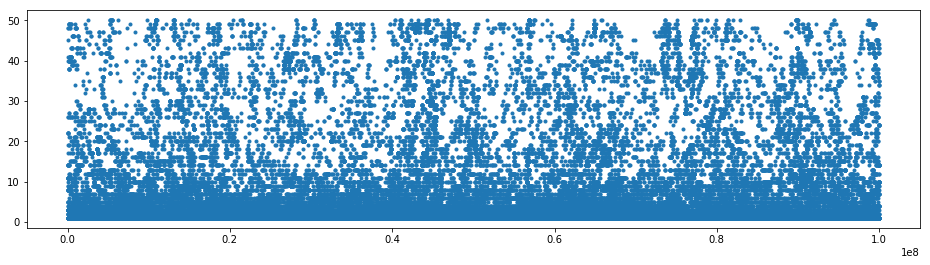

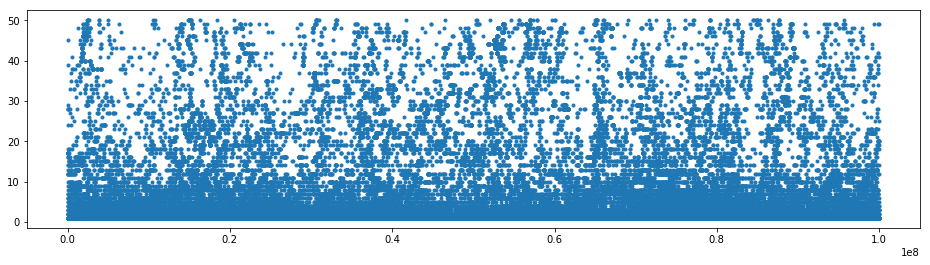

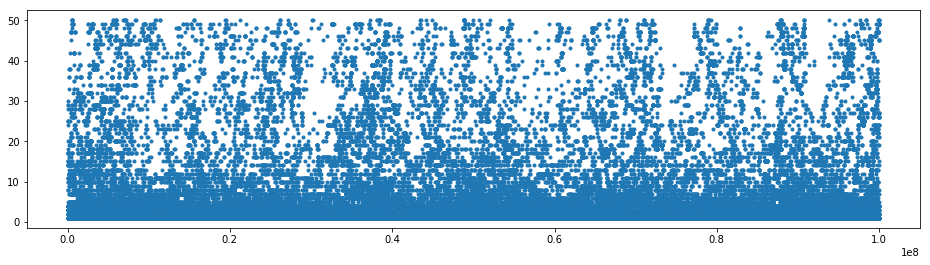

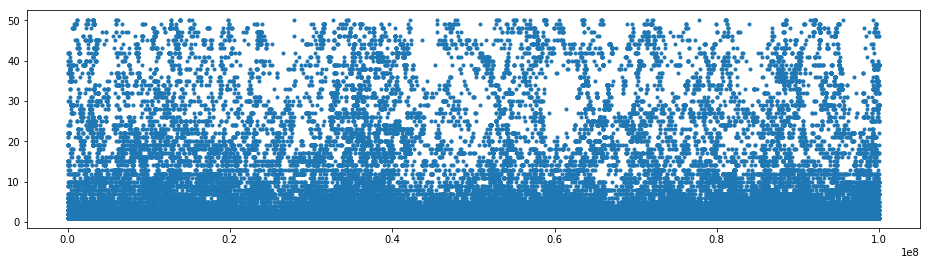

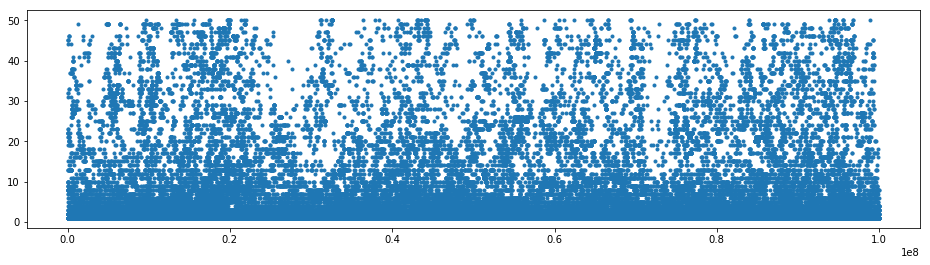

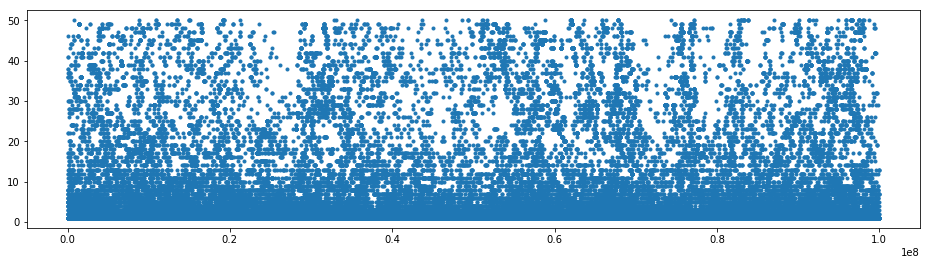

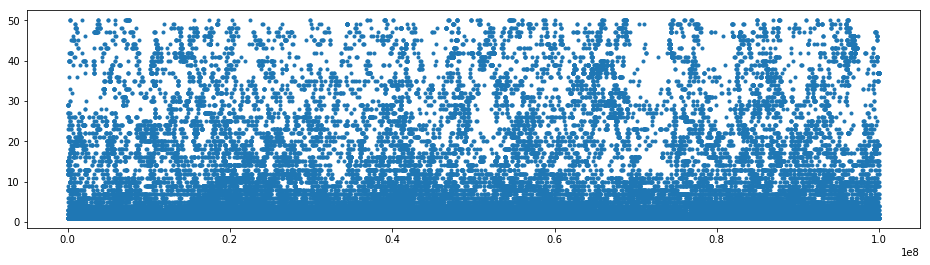

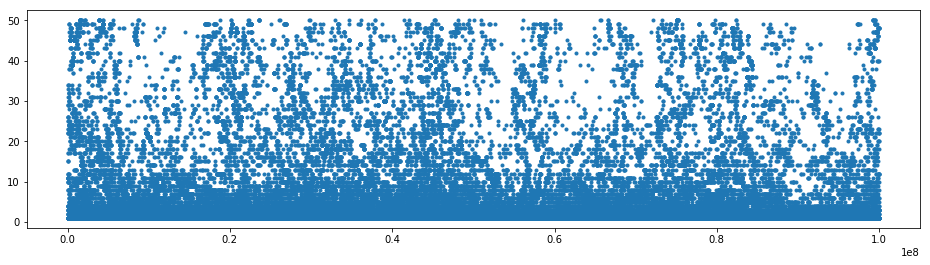

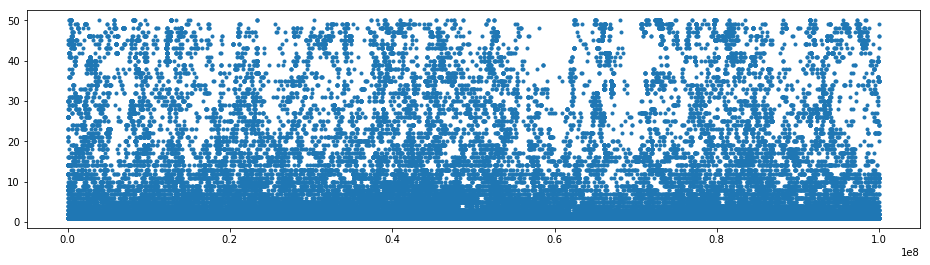

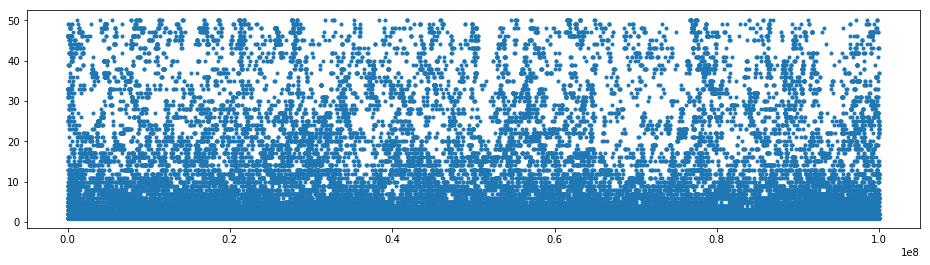

In [9]:
for i in range(n_files):
    plt.figure(figsize=(16,4))
    data = MAF[i,:]
    plt.plot(np.arange(L)[data>0], data[data>0], '.')

In [10]:
f_poly = np.sum(MAF > 0) / (n_files*L)
f_single = np.sum(MAF == 1) / (n_files*L)
f_mult = np.sum(MAF > 1) / (n_files*L)

In [12]:
pi = calc_pi(MAF, n)
pi_0 = 2*mu_n*N

In [14]:
print('Fraction polymorphic:', f_poly)
print('Fraction singleton:', f_single)
print('Fraction multiple:', f_mult)
print('Pi:', pi)
print('Pi/Pi_0:', pi/pi_0)

Fraction polymorphic: 0.000612728
Fraction singleton: 0.000167961
Fraction multiple: 0.000444767
Pi: 8.7608789697e-05
Pi/Pi_0: 0.438043948485


In [15]:
mSFS = np.histogram(MAF, bins=np.arange(n//2 + 2))[0]

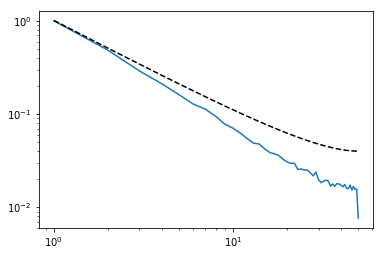

In [16]:
x = np.arange(1, n//2+1)
plt.loglog(x, mSFS[1:]/mSFS[1])
plt.loglog(x, 1/x + 1/(n-x), 'k--')

# $\pi$

In [18]:
w_superfine = 1000
w_fine = 10000
w_coarse = 1000000
PI_superfine = windowed_pi(MAF, L, w_superfine, n)
PI_fine = windowed_pi(MAF, L, w_fine, n)
PI_coarse = windowed_pi(MAF, L, w_coarse, n)

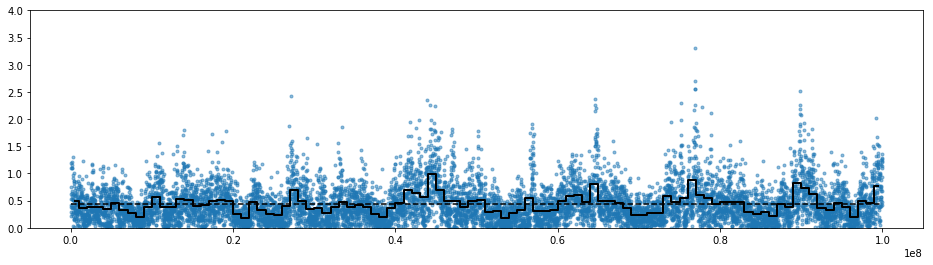

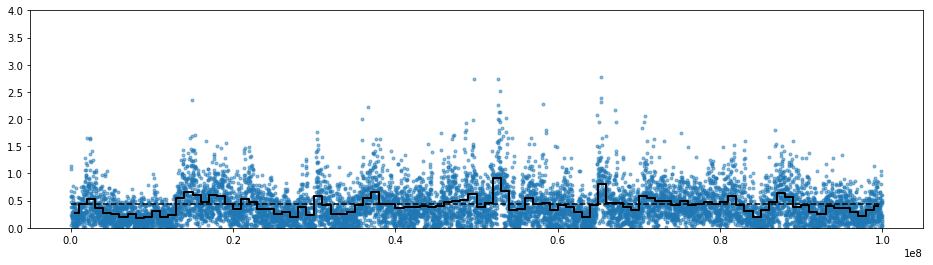

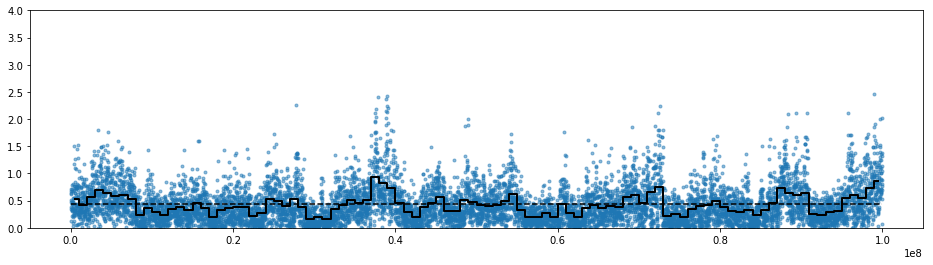

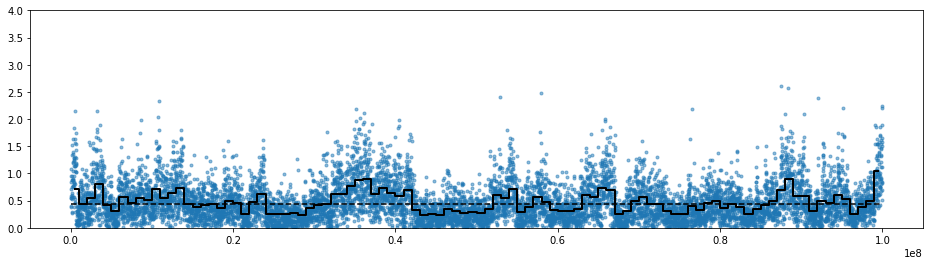

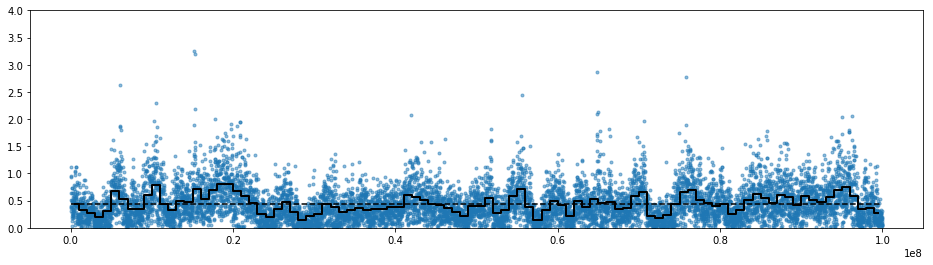

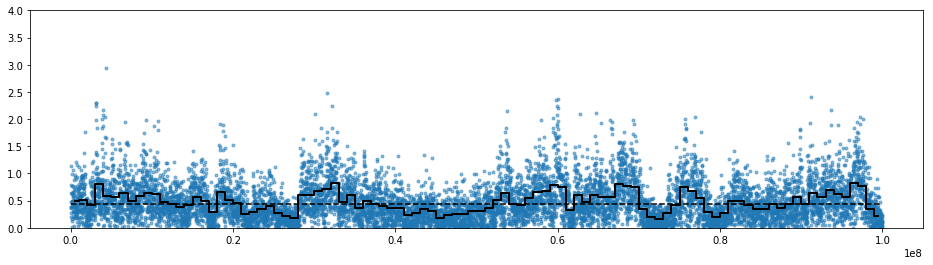

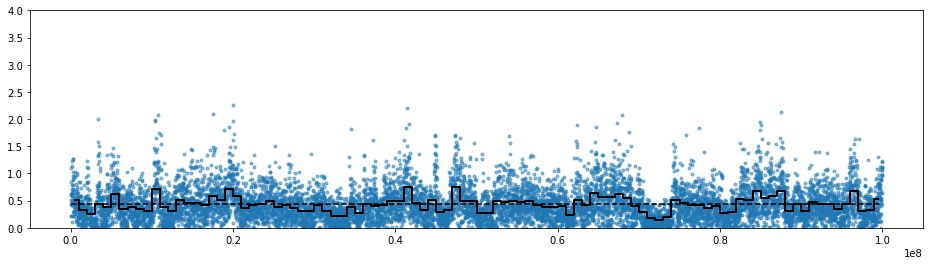

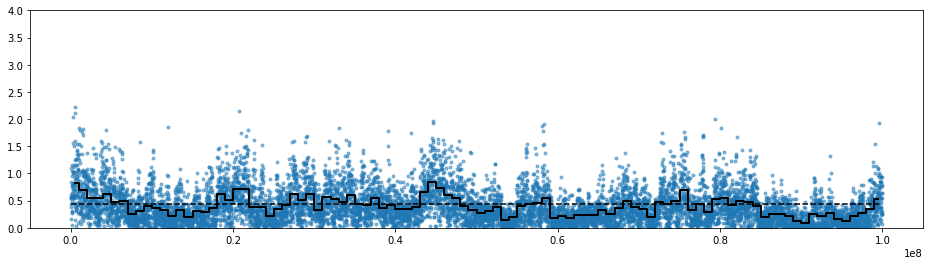

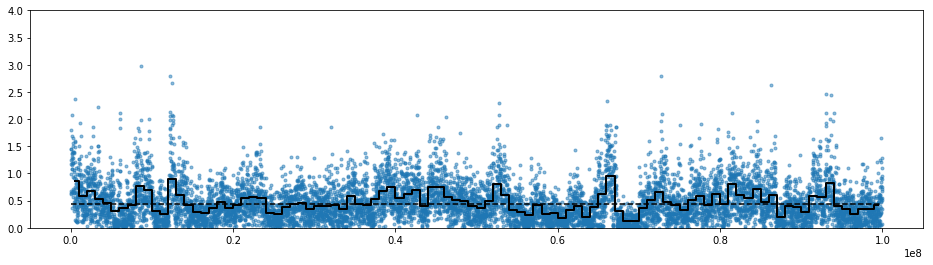

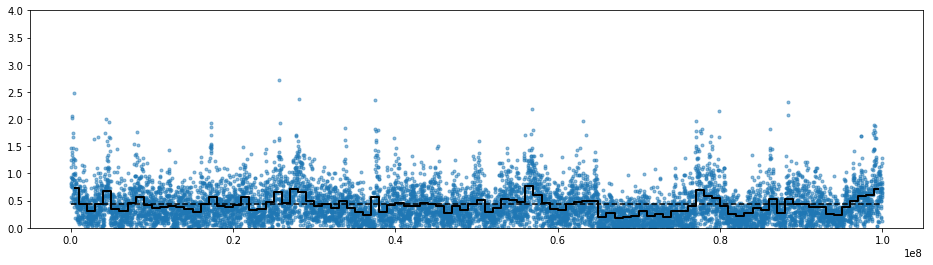

In [19]:
for i in range(n_files):
    plt.figure(figsize=(16,4))
    plt.plot(w_fine*(np.arange(L//w_fine) + 1/2), PI_fine[i,:]/pi_0, '.', alpha=0.5)
    plt.plot(w_coarse*(np.arange(L//w_coarse) + 1/2), PI_coarse[i,:]/pi_0, '-k', lw=2, drawstyle='steps-mid')
    plt.hlines(pi/pi_0, 0, L, linestyle='dashed', zorder=4)
    plt.ylim([0,4])

In [20]:
D_fine = np.arange(0, 9001, 1)
AC_fine = np.array([autocov(PI_fine, d) for d in D_fine])

(-0.1, 1.1)

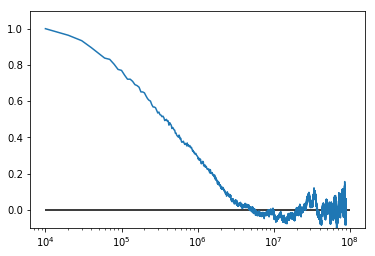

In [22]:
plt.semilogx(D_fine*w_fine, AC_fine/AC_fine[1])
plt.hlines(0, w_fine, L)
plt.ylim([-.1,1.1])

In [23]:
D_superfine = np.arange(0, 9001, 1)
AC_superfine = np.array([autocov(PI_superfine, d) for d in D_superfine])

(-0.1, 1.1)

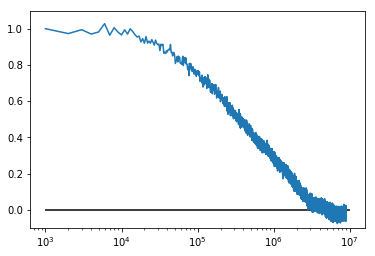

In [24]:
plt.semilogx(D_superfine*w_superfine, AC_superfine/AC_superfine[1])
plt.hlines(0, w_superfine, L/10)
plt.ylim([-.1,1.1])

(-0.1, 1.1)

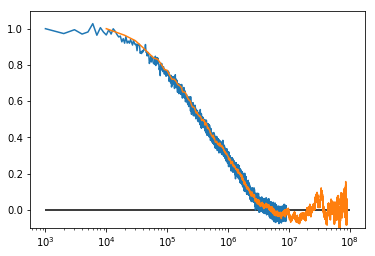

In [25]:
plt.semilogx(D_superfine*w_superfine, AC_superfine/AC_superfine[1])
plt.semilogx(D_fine*w_fine, AC_fine/AC_fine[1])
plt.hlines(0, w_superfine, L)
plt.ylim([-.1,1.1])

# SFS covar

In [26]:
def windowed_singletons(MAF, L, window_size):
    n_rows = MAF.shape[0]
    n_windows = L // window_size
    singles = np.zeros((n_rows, n_windows))
    non_singles = np.zeros((n_rows, n_windows))
    for i in range(n_windows):
        i_start = window_size * i
        i_end = window_size * (i+1)
        window = MAF[:, i_start:i_end]
        singles[:, i] = np.sum(window == 1, axis=1) / window_size
        non_singles[:, i] = np.sum(window > 1, axis=1) / window_size
    return singles, non_singles

In [27]:
SINGLES_superfine, NONSINGLES_superfine = windowed_singletons(MAF, L, w_superfine)
SINGLES_fine, NONSINGLES_fine = windowed_singletons(MAF, L, w_fine)
SINGLES_coarse, NONSINGLES_coarse = windowed_singletons(MAF, L, w_coarse)

In [28]:
def lag_cov(X1, X2, d):
    if d == 0:
        return np.cov(np.ravel(X1), np.ravel(X2))[0,1]
    else:
        return np.cov(np.ravel(X1[:,:-d]), np.ravel(X2[:,d:]))[0,1]        

In [29]:
np.mean(SINGLES_fine[2,:]*NONSINGLES_fine[2,:]) - np.mean(SINGLES_fine[2,:])*np.mean(NONSINGLES_fine[2,:])

-3.0253779999997456e-10

In [30]:
print(autocov(SINGLES_fine, 1))

1.42821062784e-09


In [31]:
print(np.cov(np.ravel(SINGLES_fine), np.ravel(NONSINGLES_fine))[0,1])
print(lag_cov(SINGLES_fine, NONSINGLES_fine, 0))
print(lag_cov(SINGLES_fine, NONSINGLES_fine, 4))

-1.18511272113e-10
-1.18511272113e-10
4.58918368616e-11


In [32]:
cov_fine = np.array([lag_cov(SINGLES_fine, NONSINGLES_fine, d) for d in D_fine])

In [33]:
cov_superfine = np.array([lag_cov(SINGLES_superfine, NONSINGLES_superfine, d) for d in D_superfine])

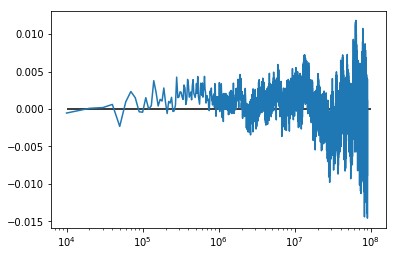

In [40]:
plt.semilogx(D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, w_fine, L)

(-0.005, 0.005)

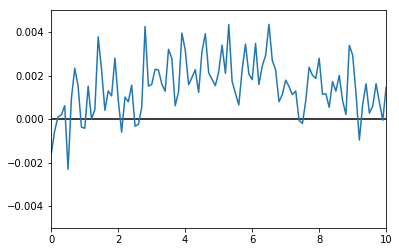

In [54]:
plt.plot(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

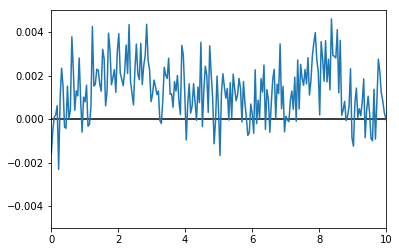

In [58]:
plt.plot(r*pi/(2*mu_n)*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

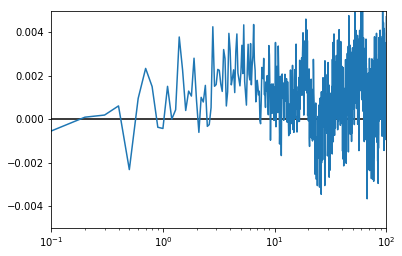

In [61]:
plt.semilogx(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, .1, L)
plt.xlim([0.1, 100])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

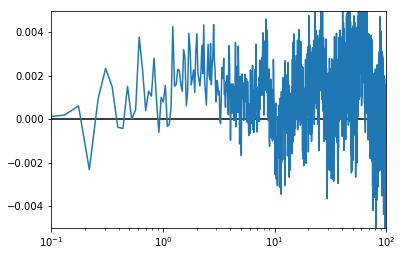

In [62]:
plt.semilogx(r*pi/(2*mu_n)*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, .1, L)
plt.xlim([0.1, 100])
plt.ylim([-0.005, 0.005])

# OLD

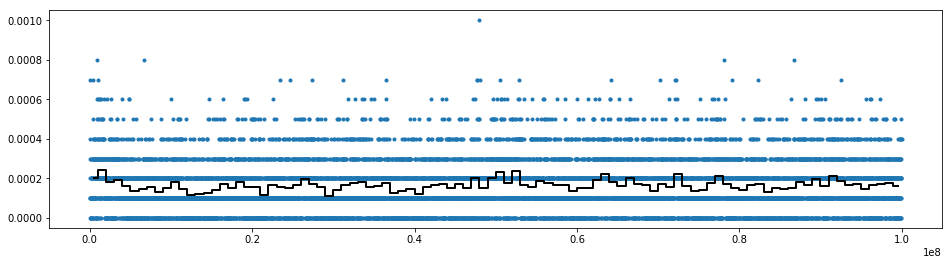

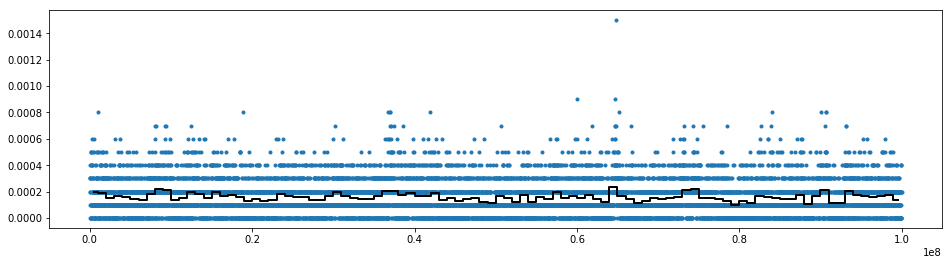

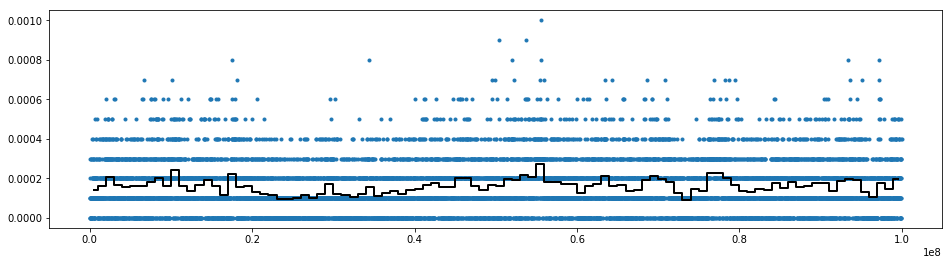

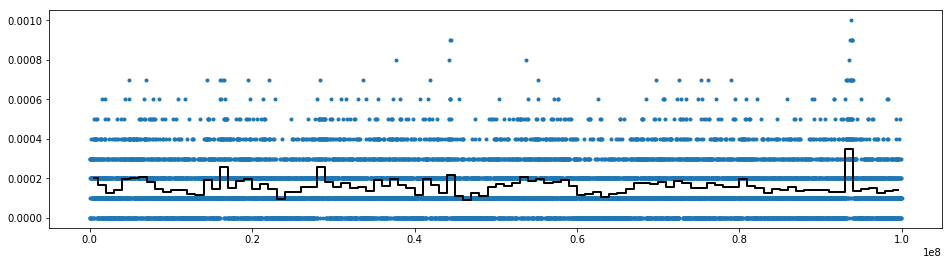

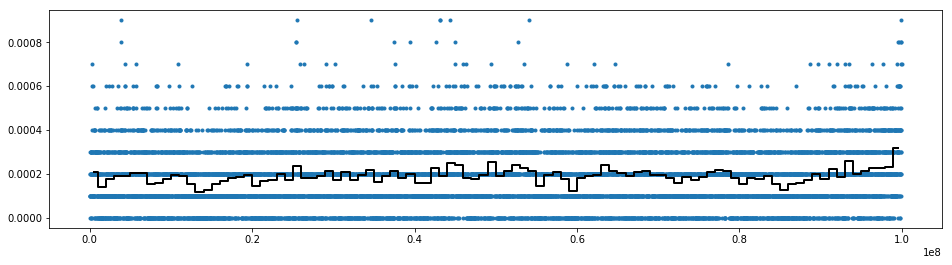

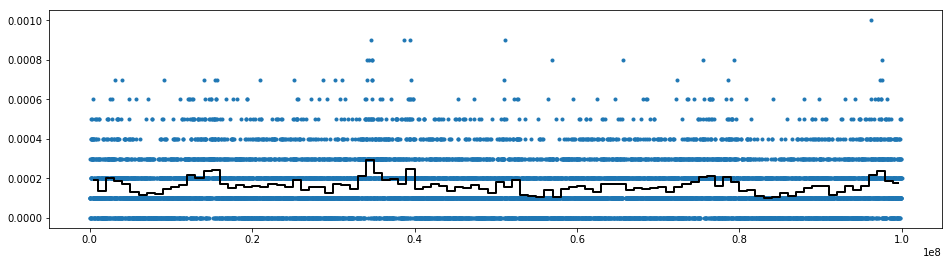

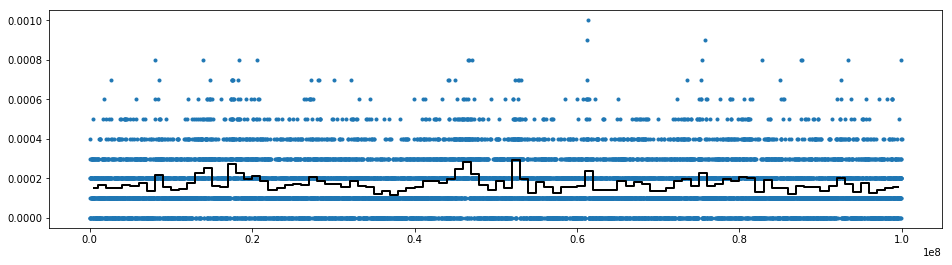

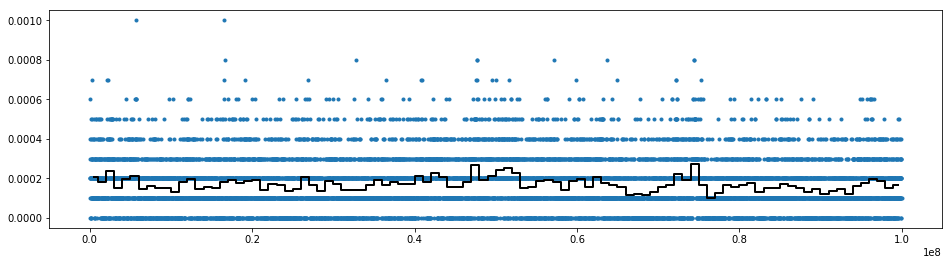

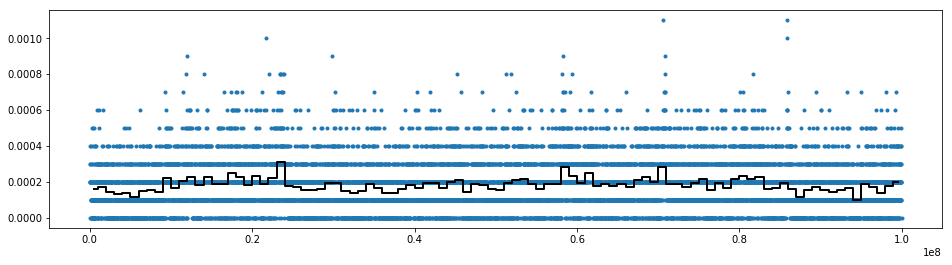

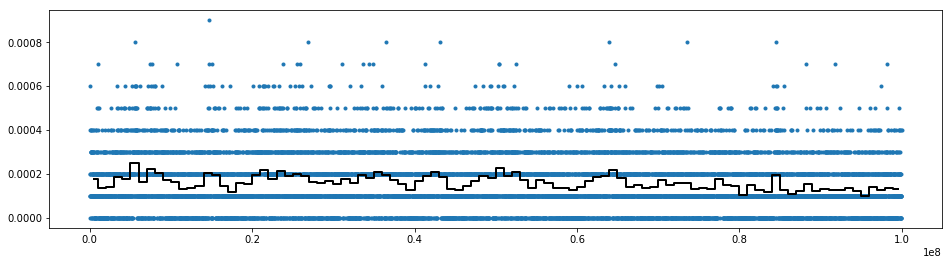

In [381]:
for i in range(n_files):
    plt.figure(figsize=(16,4))
    plt.plot(w_fine*(np.arange(L//w_fine) + 1/2), SINGLES_fine[i,:], '.')
    plt.plot(w_coarse*(np.arange(L//w_coarse) + 1/2), SINGLES_coarse[i,:], '-k', lw=2, drawstyle='steps-mid')

[[  1.75851985e-08   5.73257326e-11]
 [  5.73257326e-11   6.01659141e-08]]


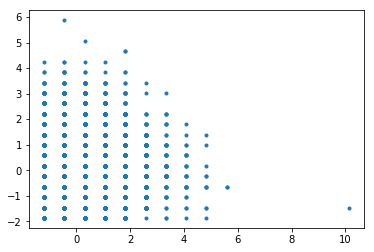

In [244]:
plt.plot((SINGLES_fine-np.mean(SINGLES_fine))/np.std(SINGLES_fine),
         (NONSINGLES_fine-np.mean(NONSINGLES_fine))/np.std(NONSINGLES_fine),
         '.')
print(np.cov(SINGLES_fine, NONSINGLES_fine))

In [134]:
print(L//w_fine)

100000


In [139]:
SFS_binned = np.zeros((w_fine, n//2))
for i in range(w_fine):
    i_start = (L//w_fine) * i
    i_end = (L//w_fine) * (i+1)
    SFS_binned[i,:] = np.histogram(MAF[i_start:i_end], bins=np.arange(n//2+2))[0][1:]

In [140]:
print(SFS_binned)

[[ 19.   8.   8. ...,   0.   0.   0.]
 [ 11.   8.   7. ...,   0.   0.   0.]
 [ 13.  13.   5. ...,   0.   0.   0.]
 ..., 
 [ 16.   6.   4. ...,   0.   0.   0.]
 [ 21.  13.   1. ...,   0.   0.   0.]
 [ 21.   9.   3. ...,   0.   0.   0.]]


In [143]:
mSFS = np.mean(SFS_binned, axis=0)
print(mSFS)

[ 16.497   7.432   5.54    2.971   2.545   2.225   1.772   1.512   1.078
   0.863   1.011   0.757   0.479   0.644   0.607   0.748   0.504   0.514
   0.411   0.464   0.49    0.458   0.379   0.404   0.506   0.421   0.339
   0.407   0.272   0.423   0.439   0.348   0.282   0.263   0.291   0.358
   0.308   0.417   0.339   0.398   0.307   0.229   0.357   0.306   0.282
   0.289   0.27    0.197   0.241   0.103]


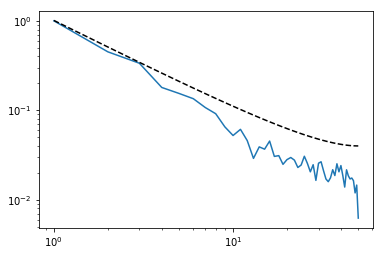

In [146]:
plt.loglog(x, mSFS/mSFS[0])
plt.loglog(x, 1/x + 1/(n-x), 'k--')

In [150]:
jSFS = np.mean(SFS_binned[:,None,:]*SFS_binned[:,:,None], axis=0) - np.eye(n//2)*mSFS

In [164]:
print(np.sum(jSFS, axis=0)/np.sum(jSFS))
print(mSFS/np.sum(mSFS))

[ 0.2729055   0.12570509  0.09091417  0.04862157  0.04355392  0.03777118
  0.03013168  0.02633011  0.01928437  0.01475624  0.01733927  0.01268814
  0.00788271  0.01143185  0.01031142  0.01359695  0.00892878  0.00924299
  0.00729454  0.00808622  0.00872051  0.00825674  0.00665353  0.00699234
  0.00863218  0.00743459  0.00589623  0.00738707  0.00500839  0.00780164
  0.00830454  0.00632478  0.00488343  0.00453232  0.00520938  0.00644275
  0.00594879  0.00723108  0.00608046  0.00801018  0.00546936  0.00403277
  0.00652326  0.00571872  0.00539556  0.00523902  0.00505927  0.00350023
  0.00447753  0.00205664]
[ 0.28105355  0.12661635  0.09438302  0.05061587  0.04335826  0.03790654
  0.03018894  0.02575941  0.0183655   0.01470263  0.01722405  0.01289674
  0.00816055  0.0109716   0.01034124  0.01274341  0.00858647  0.00875684
  0.00700206  0.007905    0.00834796  0.00780278  0.00645689  0.0068828
  0.00862054  0.00717243  0.00577542  0.00693391  0.00463397  0.0072065
  0.00747909  0.00592875  0

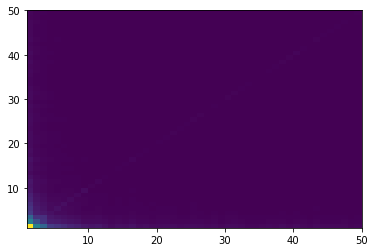

In [151]:
plt.pcolor(x,x,jSFS)

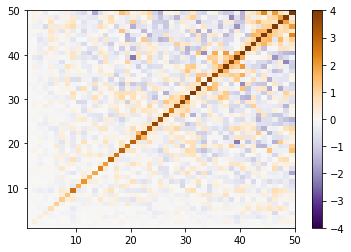

In [157]:
plt.pcolor(x,x, np.log2(jSFS/(mSFS[:,None]*mSFS[None,:])), cmap='PuOr_r', vmin=-4, vmax=4)
plt.colorbar()

In [161]:
print(jSFS)

[[  2.81788000e+02   1.21662000e+02   9.02850000e+01 ...,   3.21900000e+00
    3.90900000e+00   1.67000000e+00]
 [  1.21662000e+02   6.94060000e+01   4.02950000e+01 ...,   1.64100000e+00
    1.99600000e+00   7.99000000e-01]
 [  9.02850000e+01   4.02950000e+01   3.84180000e+01 ...,   1.02200000e+00
    1.40500000e+00   5.69000000e-01]
 ..., 
 [  3.21900000e+00   1.64100000e+00   1.02200000e+00 ...,   6.04000000e-01
    6.40000000e-02   1.20000000e-02]
 [  3.90900000e+00   1.99600000e+00   1.40500000e+00 ...,   6.40000000e-02
    1.17800000e+00   9.50000000e-02]
 [  1.67000000e+00   7.99000000e-01   5.69000000e-01 ...,   1.20000000e-02
    9.50000000e-02   4.24000000e-01]]


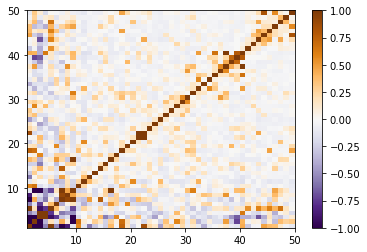

In [160]:
plt.pcolor(x,x, jSFS*np.log2(jSFS/(mSFS[:,None]*mSFS[None,:])), cmap='PuOr_r', vmin=-1, vmax=1)
plt.colorbar()